# ORAL CANCER LESION DETECTION

## Importing the needed libraries

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
from torchvision import transforms 
from sklearn.metrics import precision_score, f1_score
import numpy as np

## Creating two classes for coco transformation

In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target  

# Custom dataset class with __getitem__ to get the bboxes and labels for the test dataset
class CocoDetectionFormatted(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super().__init__(img_folder, ann_file, transform=transform)

    def __getitem__(self, idx):
        image, target_list = super().__getitem__(idx)
        
        boxes = []
        labels = []

        for obj in target_list:
            # COCO format bbox: [x, y, width, height]
            x, y, w, h = obj['bbox']
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])

        # Convert to expected format
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        return image, target


## Loading the train and test datasets

In [58]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_img_dir= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Train"
train_ann_file= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Train/Annotaion/Oral_Cancer_Annotation_Train_coco.json"
valid_img_dir= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Valid"
valid_ann_file= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Valid/Annotaion/Oral_Cancer_Annotation_Valid_coco.json"
test_img_dir= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Test"
test_ann_file= "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Test/Annotaion/Oral_Cancer_Annotation_Test_coco.json"

train_dataset = get_coco_dataset(
    img_dir= train_img_dir,
    ann_file= train_ann_file
)


val_dataset = get_coco_dataset(
    img_dir= valid_img_dir,
    ann_file= valid_ann_file
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Creating function to load Faster R-CNN with ResNet-50 backbone

In [ ]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

## Initializing the model

In [ ]:
num_classes = 2 # Background + Lesion
model = get_model(num_classes)

In [13]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Creating function to train one epoch

In [15]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

## Model Training

In [16]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Save the model's state dictionary after every epoch
    model_path = f"/kaggle/working/fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [0] Loss: 0.1565
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.1780
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.1579
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.1243
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.1010
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 0.1085
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 0.1004
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 0.1581
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 0.1072
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 0.1251
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_10.pth
Epoch [10] Loss: 0.1028
Model saved: /kaggle/working/fasterrcnn_resnet50_epoch_11.pth
Epoch [11] Loss: 0.0920
Model saved: /kaggle/working/fasterrcnn_resnet50_

## Loading the best trained model

In [17]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 2  # Background + chair + person + table

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/kaggle/working/fasterrcnn_resnet50_epoch_26.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode
print("done")

done


## Creating functions for image preparation and drawing the boundary boxes

In [73]:
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "Lesion"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(img_paths, model, prepare_image, fig_size=(6, 4)):
    num_images = len(img_paths)
    cols = min(num_images, 4)  # Adjust as needed for layout
    rows = math.ceil(num_images / cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_size[0] * cols, fig_size[1] * rows))
    axs = axs.flatten() if num_images > 1 else [axs]

    for i, image_path in enumerate(img_paths):
        image = Image.open(image_path)
        image_tensor = prepare_image(image_path)

        with torch.no_grad():
            prediction = model(image_tensor)

        ax = axs[i]
        ax.imshow(image)
        ax.axis('off')

        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()

        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:
                x_min, y_min, x_max, y_max = box
                ax.add_patch(patches.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor='r', facecolor='none'
                ))
                ax.text(
                    x_min, y_min, f"{COCO_CLASSES.get(label, 'Unknown')} ({score:.2f})",
                    color='r', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
                )

    # Hide any extra subplots if there are fewer images than grid cells
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


## Display the lesion detection on the test dataset

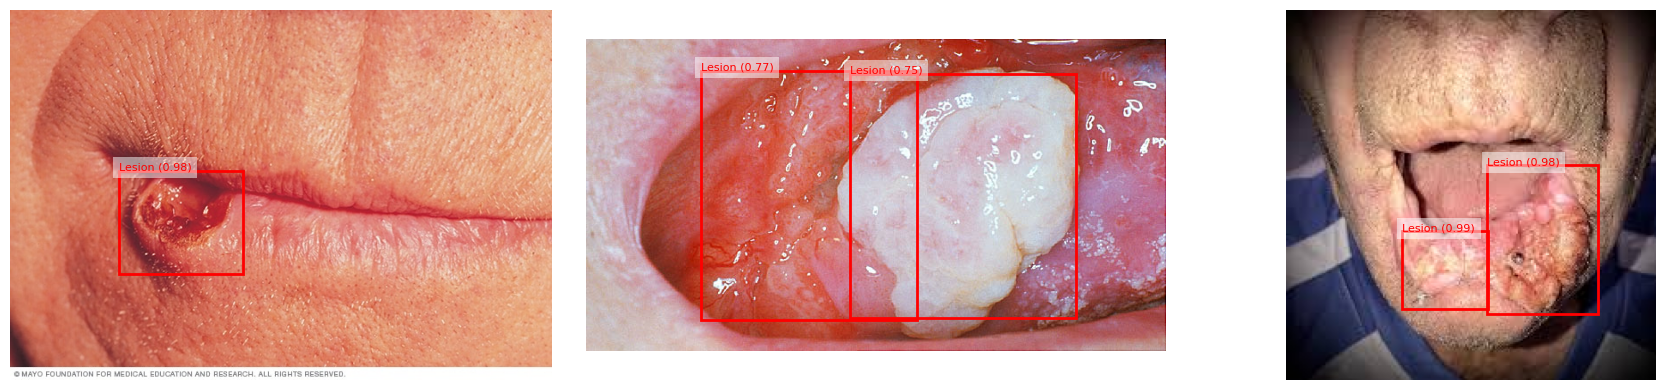

In [74]:
img_paths = [
    "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Test/ds01089_im00213_c7_lipcancerpicturethu_jpg.jpg",
    "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Test/dataset_650x350_oral_cancer_ref_guide.jpg",
    "/kaggle/input/oral-cancer-annotated-dataset/Dataset/Test/images.jpeg"
]
draw_boxes(img_paths, model, prepare_image)

## Computing the model metrics

In [ ]:
from sklearn.metrics import precision_score, f1_score

IOU_THRESHOLD = 0.5

def compute_iou(box1, box2):
    """Compute IoU between two boxes."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou

def evaluate_model(model, dataloader, device, iou_threshold=IOU_THRESHOLD):
    model.eval()
    y_true_cls = []
    y_pred_cls = []
    iou_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                pred_labels = pred['labels'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()

                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()

                # Filter out low confidence detections
                keep = pred_scores > 0.5
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_gt = set()
                for pb, pl in zip(pred_boxes, pred_labels):
                    best_iou = 0
                    best_gt_index = -1
                    for i, (gtb, gtl) in enumerate(zip(gt_boxes, gt_labels)):
                        if i in matched_gt:
                            continue
                        iou = compute_iou(pb, gtb)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_index = i

                    if best_iou >= iou_threshold:
                        y_true_cls.append(gt_labels[best_gt_index])
                        y_pred_cls.append(pl)
                        iou_scores.append(best_iou)
                        matched_gt.add(best_gt_index)
                    else:
                        # False positive
                        y_true_cls.append(0)  # Background
                        y_pred_cls.append(pl)

                # Missed ground truths (false negatives)
                for i, gtl in enumerate(gt_labels):
                    if i not in matched_gt:
                        y_true_cls.append(gtl)
                        y_pred_cls.append(0)  # Background

    # Convert to numpy
    y_true_cls = np.array(y_true_cls)
    y_pred_cls = np.array(y_pred_cls)

    # Metrics
    precision = precision_score(y_true_cls, y_pred_cls, average='binary', pos_label=1)
    f1 = f1_score(y_true_cls, y_pred_cls, average='binary', pos_label=1)
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0

    print(f"Precision: {precision:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Mean IoU : {mean_iou:.4f}")


In [85]:
transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = CocoDetectionFormatted(test_img_dir, test_ann_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

evaluate_model(model, test_loader, device)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Precision: 0.6512
F1 Score : 0.7179
Mean IoU : 0.7637
